# Downstream analysis of HPLC-Orbitrap data

This notebook replicates the analysis workflow created by Marc Rurik. The workflow wrapped in [KNIME](https://www.knime.org/) nodes can be found [here](http://www.myexperiment.org/workflows/4792.html), and is illustrated in the picture below. The workflow is developed to analyze HPLC-Orbitrap measurements split into separate or alternating m/z scan ranges. The input expects to be OpenMS consensusXML files, generated by the TextExporter in OpenMS. The workflow further combines the scan ranges, filter them ultilizing blank samples and QC measurements, and then performs statistical analysis to retrieve reliable features.

The aim of this notebook is to give an user friendly and interactive environment where you can get on-the-fly information about the progress of your data. After each step of the pipeline, we provide you with live feedback, consisting of informative plots.

<p align="center">
  <img src="http://www.myexperiment.org/workflows/4792/versions/1/previews/full"/>
</p>

Illustration by: Marc Rurik

### Read input files
* Please run the following snippet and insert the paths to your input files containing the low/high mass range

In [1]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 8 x64 (build 9200)

locale:
[1] LC_COLLATE=Swedish_Sweden.1252  LC_CTYPE=Swedish_Sweden.1252   
[3] LC_MONETARY=Swedish_Sweden.1252 LC_NUMERIC=C                   
[5] LC_TIME=Swedish_Sweden.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] R6_2.1.2           magrittr_1.5       IRdisplay_0.4.9000 pbdZMQ_0.2-3      
 [5] tools_3.2.1        crayon_1.3.2       uuid_0.1-2         stringi_1.0-1     
 [9] IRkernel_0.6       jsonlite_1.0       stringr_1.0.0      digest_0.6.10     
[13] repr_0.9           evaluate_0.9      

In [2]:
low <- read.table("low.csv", 
                  fill=TRUE, 
                  sep=",",
                  header=TRUE)
high <- read.table("high.csv", 
                  fill=TRUE, 
                  sep=",",
                  header=TRUE)

In [3]:
print("Head and tail of low mass range")
head(low)
tail(low)
print("Head and tail of high mass range")
head(high)
tail(high)

[1] "Head and tail of low mass range"


Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,...,Col217,Col218,Col219,Col220,Col221,Col222,Col223,Col224,Col225,Col226
MAP,0,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/001_CRa_H9M5_M470_Blank_01_alternate_pos_low_mr.featureXML,3529,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,1,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/002_CRa_H9M5_M470_Pool_01_alternate_pos_low_mr.featureXML,3643,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,2,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/003_CRa_H9M5_M470_Pool_02_alternate_pos_low_mr.featureXML,3733,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,3,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/005_CRa_H9M5_M470_Blank_02_alternate_pos_low_mr.featureXML,3368,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,4,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/006_CRa_H9M5_M470_H01_K1_alternate_pos_low_mr.featureXML,3762,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,5,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/007_CRa_H9M5_M470_L01_K2_alternate_pos_low_mr.featureXML,3609,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,...,Col217,Col218,Col219,Col220,Col221,Col222,Col223,Col224,Col225,Col226
7491,CONSENSUS,40.72396,144.042932983073,10717.40,0,0,0.1161080,NA,NA,NA,...,NA,NA,NA,0,NA,40.72404,144.0429,6170.83,0,0
7492,CONSENSUS,577.01710,187.152262617307,11513.80,0,0,0.0884580,NA,NA,NA,...,NA,NA,NA,0,NA,NA,NA,NA,0,NA
7493,CONSENSUS,240.90990,120.12686699577,5137.55,0,0,0.0983291,NA,NA,NA,...,NA,NA,NA,0,NA,244.61040,120.1269,2072.74,0,0
7494,CONSENSUS,704.71000,102.140147962815,39860.50,0,0,0.0984778,NA,NA,NA,...,698.292,102.1402,12694.00,0,0,702.42600,102.1401,13620.40,0,0
7495,CONSENSUS,666.24500,157.083563630763,8168.84,0,0,0.0986946,NA,NA,NA,...,671.232,157.0835,5690.31,0,0,662.80800,157.0835,8013.49,0,0
7496,CONSENSUS,720.71200,173.078621727319,9856.46,0,0,0.1031250,NA,NA,NA,...,NA,NA,NA,0,NA,721.75200,173.0786,6624.58,0,0


[1] "Head and tail of high mass range"


Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,...,Col217,Col218,Col219,Col220,Col221,Col222,Col223,Col224,Col225,Col226
MAP,0,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/001_CRa_H9M5_M470_Blank_01_alternate_pos_high_mr.featureXML,13732,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,1,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/002_CRa_H9M5_M470_Pool_01_alternate_pos_high_mr.featureXML,15731,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,2,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/003_CRa_H9M5_M470_Pool_02_alternate_pos_high_mr.featureXML,15421,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,3,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/005_CRa_H9M5_M470_Blank_02_alternate_pos_high_mr.featureXML,12755,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,4,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/006_CRa_H9M5_M470_H01_K1_alternate_pos_high_mr.featureXML,16004,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,5,C:/Users/UU/AppData/Local/Temp/2017-02-08_093607_The-big-daddy_26280_1/TOPPAS_tmp/pipeline_OpenMS/003_FeatureFinderMetabo/out/007_CRa_H9M5_M470_L01_K2_alternate_pos_high_mr.featureXML,14319,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,...,Col217,Col218,Col219,Col220,Col221,Col222,Col223,Col224,Col225,Col226
29228,CONSENSUS,626.1360,884.508695651021,16942.40,0,0,0.0605625,NA,NA,NA,...,624.8340,884.5052,20278.20,0,0,630.6420,884.5075,37412.30,0,0
29229,CONSENSUS,546.5762,399.763611093262,8066.69,0,0,0.0885413,NA,NA,NA,...,NA,NA,NA,0,NA,553.3326,399.7638,11144.10,0,0
29230,CONSENSUS,509.3905,329.211151903685,5671.43,0,0,0.0878894,NA,NA,NA,...,500.2062,329.2113,1235.77,0,0,509.8698,329.2113,13276.10,0,0
29231,CONSENSUS,668.2470,569.490718897502,8816.73,0,0,0.0855869,NA,NA,NA,...,666.8880,569.4906,10079.70,0,0,667.1580,569.4920,12932.90,0,0
29232,CONSENSUS,484.4279,841.715961572296,9596.41,0,0,0.0862566,NA,NA,NA,...,NA,NA,NA,0,NA,NA,NA,NA,0,NA
29233,CONSENSUS,573.3078,824.651647569785,13082.60,0,0,0.0790781,NA,NA,NA,...,581.3484,824.6526,6544.37,0,0,576.5256,824.6497,8782.03,0,0


* Source .rscripts

In [4]:
source('Functions.R')

[1] "The functions were succesfully loaded"


* Parse the files

In [5]:
low_parsed <- Parse(low)
high_parsed <- Parse(high)

In [6]:
cat("Size of low mass range matrix:", dim(low_parsed))
head(low_parsed)
cat("Size of high mass range matrix: ", dim(high_parsed))
head(high_parsed)

Size of low mass range matrix: 7452 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_alternate_pos_low_mr.featureXML,002_CRa_H9M5_M470_Pool_01_alternate_pos_low_mr.featureXML,003_CRa_H9M5_M470_Pool_02_alternate_pos_low_mr.featureXML,005_CRa_H9M5_M470_Blank_02_alternate_pos_low_mr.featureXML,006_CRa_H9M5_M470_H01_K1_alternate_pos_low_mr.featureXML,007_CRa_H9M5_M470_L01_K2_alternate_pos_low_mr.featureXML,008_CRa_H9M5_M470_H14_K1_alternate_pos_low_mr.featureXML,009_CRa_H9M5_M470_Blank_03_alternate_pos_low_mr.featureXML,...,037_CRa_H9M5_M470_Blank_09_alternate_pos_low_mr.featureXML,038_CRa_H9M5_M470_L14_K3_alternate_pos_low_mr.featureXML,039_CRa_H9M5_M470_C03_K2_alternate_pos_low_mr.featureXML,040_CRa_H9M5_M470_L03_K1_alternate_pos_low_mr.featureXML,041_CRa_H9M5_M470_Blank_10_alternate_pos_low_mr.featureXML,042_CRa_H9M5_M470_Pool_06_alternate_pos_low_mr.featureXML,044_CRa_H9M5_M470_L14_K1_alternate_pos_low_mr.featureXML,045_CRa_H9M5_M470_L14_K2_alternate_pos_low_mr.featureXML,046_CRa_H9M5_M470_H03_K3_alternate_pos_low_mr.featureXML,047_CRa_H9M5_M470_Blank_11_alternate_pos_low_mr.featureXML
7088,55.0180536900687,573.95,NA,NA,NA,NA,NA,NA,NA,NA,...,8923.16015625,NA,NA,NA,NA,NA,NA,NA,6818.490234375,NA
7093,55.0418510587728,559.7794,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,9215.6796875,NA,NA,NA,NA,NA,NA
3271,55.0418515292256,522.389723076923,5152.7900390625,NA,NA,NA,5536.97021484375,NA,NA,NA,...,NA,NA,NA,12883.5,10291.5,NA,NA,NA,NA,15469.7001953125
5851,55.0418564031016,464.940942857143,4063.67993164063,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,10761.400390625
6578,55.0418568723511,443.5208,8467.98046875,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,1884.61999511719,10369.7998046875,NA,NA,NA,NA,NA
7322,55.041862314662,511.6493,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,4389.18994140625,NA,NA,NA,NA,NA,NA


Size of high mass range matrix:  29189 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_alternate_pos_high_mr.featureXML,002_CRa_H9M5_M470_Pool_01_alternate_pos_high_mr.featureXML,003_CRa_H9M5_M470_Pool_02_alternate_pos_high_mr.featureXML,005_CRa_H9M5_M470_Blank_02_alternate_pos_high_mr.featureXML,006_CRa_H9M5_M470_H01_K1_alternate_pos_high_mr.featureXML,007_CRa_H9M5_M470_L01_K2_alternate_pos_high_mr.featureXML,008_CRa_H9M5_M470_H14_K1_alternate_pos_high_mr.featureXML,009_CRa_H9M5_M470_Blank_03_alternate_pos_high_mr.featureXML,...,037_CRa_H9M5_M470_Blank_09_alternate_pos_high_mr.featureXML,038_CRa_H9M5_M470_L14_K3_alternate_pos_high_mr.featureXML,039_CRa_H9M5_M470_C03_K2_alternate_pos_high_mr.featureXML,040_CRa_H9M5_M470_L03_K1_alternate_pos_high_mr.featureXML,041_CRa_H9M5_M470_Blank_10_alternate_pos_high_mr.featureXML,042_CRa_H9M5_M470_Pool_06_alternate_pos_high_mr.featureXML,044_CRa_H9M5_M470_L14_K1_alternate_pos_high_mr.featureXML,045_CRa_H9M5_M470_L14_K2_alternate_pos_high_mr.featureXML,046_CRa_H9M5_M470_H03_K3_alternate_pos_high_mr.featureXML,047_CRa_H9M5_M470_Blank_11_alternate_pos_high_mr.featureXML
103,200.082899504488,523.396513636364,48091,43439.30078125,38923.6015625,25092.19921875,22600.19921875,19057.599609375,21935.80078125,20270.099609375,...,3554.76000976563,7382.7001953125,9447.6298828125,4446.22998046875,1231.08996582031,7610.52978515625,8558.7099609375,10256,5677.9501953125,7378.0400390625
18940,200.082912443134,529.797763636363,NA,NA,NA,7813.77978515625,NA,4404.58984375,NA,NA,...,3574.22998046875,NA,NA,NA,5883.27001953125,4490.93994140625,3563.919921875,4753.93017578125,NA,NA
21096,200.106894984858,485.076266666667,2837.11010742188,5084.85986328125,NA,NA,NA,NA,NA,NA,...,NA,4122.43994140625,NA,NA,NA,4109.759765625,3862.68994140625,NA,3233.60009765625,NA
5855,200.128167479438,693.207517241379,NA,10796.5,NA,6929.3701171875,3307.1298828125,NA,NA,2530.61010742188,...,6391.08984375,NA,8396.5703125,20392.30078125,16953.30078125,5473.06982421875,5601.60009765625,16865.400390625,5741.77978515625,NA
14418,200.128181657,595.86132,NA,NA,26511,NA,NA,NA,25436.900390625,26622.099609375,...,NA,20934.900390625,15893.900390625,NA,NA,NA,NA,NA,27391.400390625,24482.69921875
29019,200.128187525699,649.42,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,9340.2099609375,NA,NA,NA,4363.10986328125,NA,NA,NA,NA


* Rename columns

In [7]:
low_renamed <- renameColumns(low_parsed)
high_renamed <- renameColumns(high_parsed)

if (ncol(low_renamed)!=ncol(high_renamed)) {
    if (ncol(low_renamed>ncol(high_renamed))) {
        warning("Samples are missing in the high mass range")
    } else {
        warning("Samples are missing in the low mass range")
    }
}

print(names(low_renamed))

Warning message:
"package 'stringr' was built under R version 3.2.2"

 [1] "mz"       "rt"       "Blank_01" "Pool_01"  "Pool_02"  "Blank_02"
 [7] "H01_K1"   "L01_K2"   "H14_K1"   "Blank_03" "L03_K3"   "C14_K2"  
[13] "C01_K1"   "Blank_04" "Pool_03"  "H14_K2"   "H01_K2"   "H03_K1"  
[19] "Blank_05" "C01_K3"   "C14_K3"   "L03_K2"   "Blank_06" "Pool_04" 
[25] "C03_K1"   "H03_K2"   "H14_K3"   "Blank_07" "L01_K3"   "C14_K1"  
[31] "H01_K3"   "Blank_08" "Pool_05"  "L01_K1"   "C01_K2"   "C03_K3"  
[37] "Blank_09" "L14_K3"   "C03_K2"   "L03_K1"   "Blank_10" "Pool_06" 
[43] "L14_K1"   "L14_K2"   "H03_K3"   "Blank_11"


* Concatenate the scan ranges

In [8]:
data <- rbind(low_renamed, high_renamed[,names(low_renamed)])
names(data)<-gsub("_",".",names(data))
cat("Number of features: ", nrow(data))

Number of features:  36641

### Blank Filter

In [9]:
blankFilterPassed = 20 #Percentage, if the median blank intesity is more than X% of the sample intensity --> contaminant 
data.bf <- blankFilter(data,blankFilterPassed) 

431 number of features passed 


### ConsensusMap Normalization

In [10]:
# set parameters
ignoreColsPattern = c("TCA", "Blank")
method = "mean"
outlier = c(0.68, 1/0.68)
verbose = TRUE

data.bf.norm <- consensusMapNormalization(data.bf, ignoreColsPattern, method, outlier, verbose)

Maps: 


 [1] "mz"       "rt"       "Blank.01" "Pool.01"  "Pool.02"  "Blank.02"
 [7] "H01.K1"   "L01.K2"   "H14.K1"   "Blank.03" "L03.K3"   "C14.K2"  
[13] "C01.K1"   "Blank.04" "Pool.03"  "H14.K2"   "H01.K2"   "H03.K1"  
[19] "Blank.05" "C01.K3"   "C14.K3"   "L03.K2"   "Blank.06" "Pool.04" 
[25] "C03.K1"   "H03.K2"   "H14.K3"   "Blank.07" "L01.K3"   "C14.K1"  
[31] "H01.K3"   "Blank.08" "Pool.05"  "L01.K1"   "C01.K2"   "C03.K3"  
[37] "Blank.09" "L14.K3"   "C03.K2"   "L03.K1"   "Blank.10" "Pool.06" 
[43] "L14.K1"   "L14.K2"   "H03.K3"   "Blank.11"


Non-normalized columns: 


 [1] "mz"       "rt"       "Blank.01" "Blank.02" "Blank.03" "Blank.04"
 [7] "Blank.05" "Blank.06" "Blank.07" "Blank.08" "Blank.09" "Blank.10"
[13] "Blank.11"


Feature count:


[1] Pool.01: 390
[1] Pool.02: 392
[1] H01.K1: 400
[1] L01.K2: 354
[1] H14.K1: 384
[1] L03.K3: 414
[1] C14.K2: 330
[1] C01.K1: 409
[1] Pool.03: 403
[1] H14.K2: 392
[1] H01.K2: 365
[1] H03.K1: 391
[1] C01.K3: 408
[1] C14.K3: 407
[1] L03.K2: 412
[1] Pool.04: 412
[1] C03.K1: 415
[1] H03.K2: 398
[1] H14.K3: 394
[1] L01.K3: 412
[1] C14.K1: 404
[1] H01.K3: 415
[1] Pool.05: 406
[1] L01.K1: 414
[1] C01.K2: 399
[1] C03.K3: 409
[1] L14.K3: 408
[1] C03.K2: 384
[1] L03.K1: 421
[1] Pool.06: 408
[1] L14.K1: 411
[1] L14.K2: 388
[1] H03.K3: 410


Most features:


[1] L03.K1: 421


Normalization ratios (map with most features / other map):
Method: mean
Outlier: 0.68 < ratio < 1.5


[1] L03.K1 / Pool.01 = 1.07384791078873
[1] L03.K1 / Pool.02 = 1.07330615340212
[1] L03.K1 / H01.K1 = 1.04372597329615
[1] L03.K1 / L01.K2 = 1.09998226576108
[1] L03.K1 / H14.K1 = 1.03557334607072
[1] L03.K1 / L03.K3 = 1.03050287385381
[1] L03.K1 / C14.K2 = 1.08446780091909
[1] L03.K1 / C01.K1 = 0.956021843062739
[1] L03.K1 / Pool.03 = 1.00049929294888
[1] L03.K1 / H14.K2 = 1.00543167808266
[1] L03.K1 / H01.K2 = 1.06817899680662
[1] L03.K1 / H03.K1 = 0.998544632527534
[1] L03.K1 / C01.K3 = 1.10838865668672
[1] L03.K1 / C14.K3 = 1.0624156439074
[1] L03.K1 / L03.K2 = 0.901461877879964
[1] L03.K1 / Pool.04 = 0.990010677770572
[1] L03.K1 / C03.K1 = 1.07753992618104
[1] L03.K1 / H03.K2 = 0.974008172134051
[1] L03.K1 / H14.K3 = 1.02615665985362
[1] L03.K1 / L01.K3 = 1.07229917470642
[1] L03.K1 / C14.K1 = 1.11436575092173
[1] L03.K1 / H01.K3 = 1.08741777995932
[1] L03.K1 / Pool.05 = 1.03756510239969
[1] L03.K1 / L01.K1 = 1.09571096183636
[1] L03.K1 / C01.K2 = 0.92331709950853
[1] L03.K1 / C03

* Plot the log2 intensity and TIC distribution before and after normalization

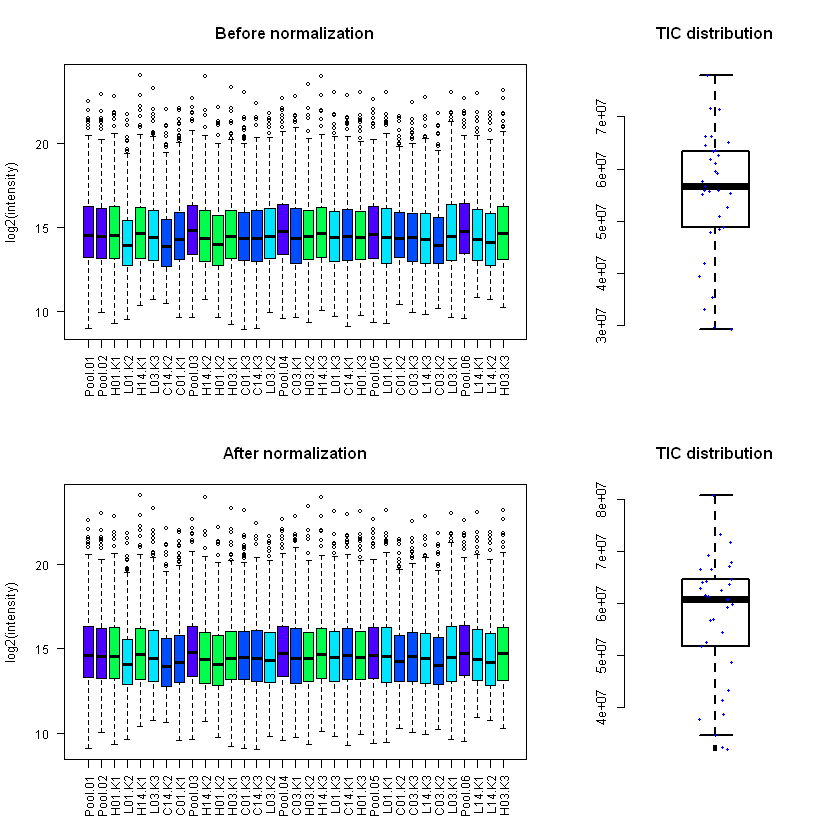

In [12]:
TIC<-colSums(apply(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)], 2, as.numeric), na.rm=T)
TICnorm<-colSums(data.bf.norm$df[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)], na.rm=T)

# Boxplots before and after normalization
n <- ncol(data.matrix(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)])) + 7

cc <- rep("black", length(names(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)])))
cc[grep("Pool", names(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)]))] <- topo.colors(5)[1]
cc[grep("C", names(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)]))] <- topo.colors(5)[2]
cc[grep("L", names(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)]))] <- topo.colors(5)[3]
cc[grep("H", names(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)]))] <- topo.colors(5)[4]

layout(matrix(c(1, 1, 2, 3, 3, 4), nrow = 2, byrow = TRUE))
boxplot(log2(data.matrix(data.bf[,-which(names(data.bf) %in% data.bf.norm$ignoredCols)])), 
        main="Before normalization",
        col=cc,las=2, cex.axis=0.9, ylab="log2(intensity)")
boxplot(TIC,lwd = 2, frame=F, main="TIC distribution")
stripchart(TIC, vertical = TRUE, 
    method = "jitter", add = TRUE, pch = 20, col = 'blue')
boxplot(log2(data.matrix(data.bf.norm$df[,-which(names(data.bf.norm$df) %in% data.bf.norm$ignoredCols)])), 
        main="After normalization",
        col=cc, las=2, cex.axis=0.9, ylab="log2(intensity)")
boxplot(TICnorm,lwd = 2, frame=F, main="TIC distribution")
stripchart(TICnorm, vertical = TRUE, 
    method = "jitter", add = TRUE, pch = 20, col = 'blue')
par(mfrow=c(1,1))

### Filtering on pools, RSD and biological replicates

In [13]:
# set parameters
poolFilterCount = 5
biolReplFilterCount = 2
numReplicates = 3
maxRSD = 25

data.bf.norm.filt <- QAFilter(data.bf.norm$df, poolFilterCount, biolReplFilterCount, numReplicates, maxRSD)
cat(nrow(data.bf.norm.filt), "number of features left")

297 number of features left

### Handle missing values

In [14]:
data.bf.norm.filt.imputed <- missingValues(data.bf.norm.filt)

### Plot figure 3 in the paper

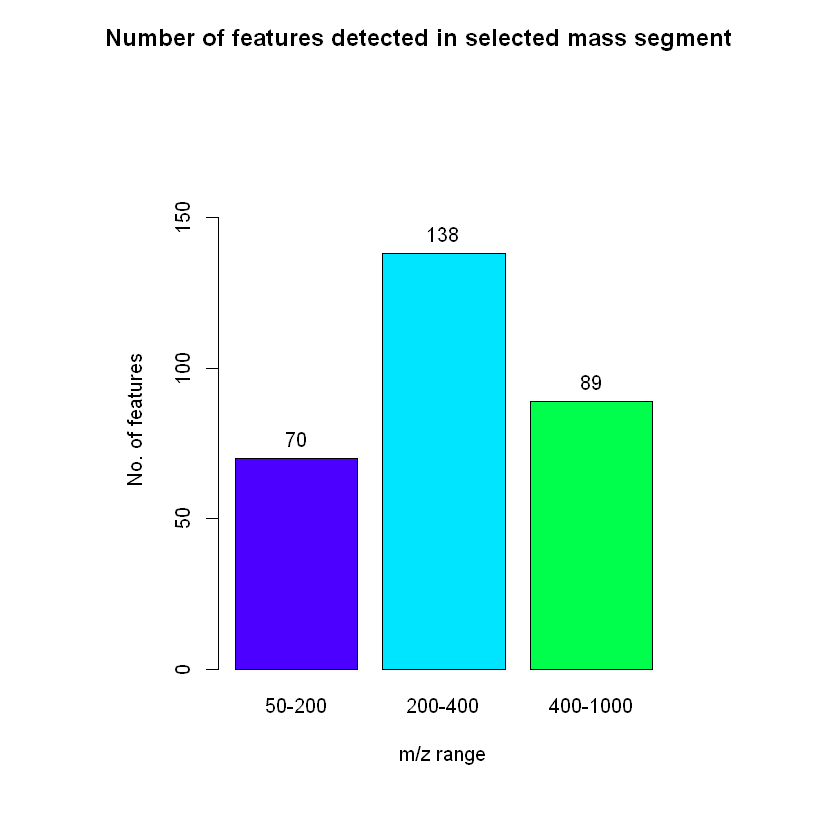

In [15]:
low_mass <- sum(as.numeric(data.bf.norm.filt.imputed$mz)<200)
mid_mass <- sum(as.numeric(data.bf.norm.filt.imputed$mz)>200 & as.numeric(data.bf.norm.filt.imputed$mz)<400)
high_mass <- sum(as.numeric(data.bf.norm.filt.imputed$mz)>400 & as.numeric(data.bf.norm.filt.imputed$mz)<1000)

data <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))

ylimit <- c(0, 1.2*max(data$y))
par(oma=c(2,5,3,5))
xx <- barplot(data$y, 
              names.arg=data$x, 
              ylim=ylimit,
              ylab="No. of features", 
              xlab="m/z range",
              col=topo.colors(6))
text(x=xx,
     y=data$y,
     label=data$y,
     pos = 3)
title("Number of features detected in selected mass segment", outer = TRUE)

### Statistical Analysis

In [16]:
stat_features <- statisticalAnalysis(data.bf.norm.filt.imputed)

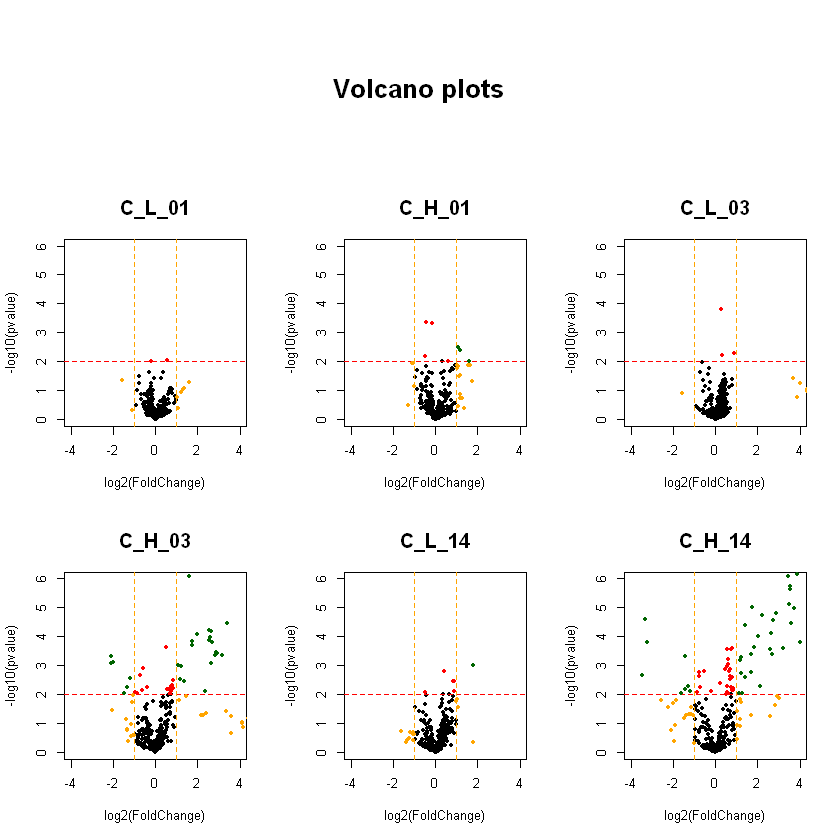

In [17]:
source('multiplot.R')
FoldChange <- data.frame(stat_features[,grep("fc", names(stat_features))])
pvalues <- data.frame(stat_features[,grep("pval", names(stat_features))])
header <- gsub("_pval", "",names(pvalues))
par(mfrow=c(2,length(FoldChange)/2), oma= c(0,0,11,0), cex.main= 2)
for (i in 1:length(FoldChange)) {
    plot(log2(FoldChange[,i]),
         -log10(pvalues[,i]),
         pch=20, 
         #xlim=c(-max(log2(FoldChange[,i])),max(log2(FoldChange[,i]))), 
         xlim=c(-4,4),
         ylim=c(0,6),
         main = header[i],
         cex.main= 1.5,
         xlab = "log2(FoldChange)", 
         ylab = "-log10(pvalue)")
    
        fc <- which(abs(log2(FoldChange[,i]))>1)
        p <- which(-log10(pvalues[,i])>-log10(0.01))
        fc_p <- intersect(fc,p)
  
        abline(h=-log10(0.01), col="red", lty=2)
        abline(v=1, col="orange", lty=2)
        abline(v=-1, col="orange", lty=2)
  
        points(log2(FoldChange[fc,i]),    # orange = high fold change 
           -log10(pvalues[fc,i]), 
           col="orange", pch=20)
    
        points(log2(FoldChange[p,i]),     # red = low p-value
           -log10(pvalues[p,i]), 
           col="red", pch=20)
    
        points(log2(FoldChange[fc_p,i]),  # green = high fold change and low p_value
           -log10(pvalues[fc_p,i]), 
           col="darkgreen", pch=20)          
}
title("Volcano plots", outer=TRUE) 

### Export result as .csv

In [18]:
write.csv(stat_features,"result.csv", row.names = F)